# HAR Experiment using LSTM
- data source: combined data from 2 data collection sessions
- preprocessing:
    3. standardise light data & CSI data
- train test split of 80:20.
- validation split during training is 0.2
- train model
- test model

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
os.getcwd()

'd:\\fyp_mds5\\model'

In [3]:
# define list of pilot and null subcarriers for 20MHz
pilot_carrier_cols =  ['csi_channel_' + str(x+32) for x in [-21, -7, 21,  7]]
null_carrier_cols =  ['csi_channel_' + str(x+32) for x in [-32, -31, -30, -29, 31,  30,  29,  0]]
remove_subcarrier_cols = pilot_carrier_cols + null_carrier_cols

## Read Activity Files

In [4]:
# generate iterator of jpg files in a list of directories
def data_files_iter(dir):
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            fname = os.path.join(dir, file)
            components = fname.split("\\")[-1]
            fname_tokens = components.split("_")
            label, idx = fname_tokens[0], fname_tokens[1]
            yield fname, label

In [5]:
file_lst = os.listdir(r"..\dataset\230510_combined_data")

In [6]:
for fname, label in data_files_iter(r"..\dataset\230510_combined_data"):
    print(fname, label)

..\dataset\230510_combined_data\empty_0.csv empty
..\dataset\230510_combined_data\empty_1.csv empty
..\dataset\230510_combined_data\empty_10.csv empty
..\dataset\230510_combined_data\empty_11.csv empty
..\dataset\230510_combined_data\empty_12.csv empty
..\dataset\230510_combined_data\empty_13.csv empty
..\dataset\230510_combined_data\empty_14.csv empty
..\dataset\230510_combined_data\empty_15.csv empty
..\dataset\230510_combined_data\empty_16.csv empty
..\dataset\230510_combined_data\empty_17.csv empty
..\dataset\230510_combined_data\empty_18.csv empty
..\dataset\230510_combined_data\empty_19.csv empty
..\dataset\230510_combined_data\empty_2.csv empty
..\dataset\230510_combined_data\empty_20.csv empty
..\dataset\230510_combined_data\empty_21.csv empty
..\dataset\230510_combined_data\empty_22.csv empty
..\dataset\230510_combined_data\empty_23.csv empty
..\dataset\230510_combined_data\empty_24.csv empty
..\dataset\230510_combined_data\empty_25.csv empty
..\dataset\230510_combined_data\em

## Data Preparation

In [7]:
def read_files(activity_data):
    results = []
    for i in range(len(activity_data)):
        df = pd.read_csv(activity_data[i], sep=",", header=None)
        results.append(df.values)    
    return results

def get_label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1) 

In [8]:
all_data_files = [(f, lbl) for f, lbl in data_files_iter(r"..\dataset\230510_combined_data")]
empty_files = [tup[0] for tup in all_data_files if tup[1] == 'empty']
stand_files = [tup[0] for tup in all_data_files if tup[1] == 'stand']
sit_files = [tup[0] for tup in all_data_files if tup[1] == 'sit']
walk_files = [tup[0] for tup in all_data_files if tup[1] == 'walk']

In [9]:
empty_data = read_files(empty_files)
stand_data = read_files(stand_files)
sit_data = read_files(sit_files)
walk_data = read_files(walk_files)

empty_label = get_label(empty_data, 'empty')
stand_label = get_label(stand_data, 'stand')
sit_label = get_label(sit_data, 'sit')
walk_label = get_label(walk_data, 'walk')

In [10]:
# concatenate all samples
X = np.vstack((empty_data, stand_data, sit_data, walk_data))
# concatenate all labels
y = np.vstack((empty_label, stand_label, sit_label, walk_label))

In [12]:
# randomise samples
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=5)

## Split train and test datasets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Perform Data Standardisation

In [14]:
# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin

class Standard_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

sc = Standard_Scaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
## one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

In [16]:
from pickle import dump

# save preprocessing objects
obj_save_dir = 'v2_obj'
if not os.path.exists(obj_save_dir):
    os.makedirs(obj_save_dir)
dump(sc, open('v2_obj/scaler.pkl', 'wb'))
dump(ohe, open('v2_obj/ohe.pkl', 'wb'))

## LSTM model

In [17]:
activity_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = tf.keras.optimizers.Adam(learning_rate=1e-8)

activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model_history = activity_model.fit(X_train, y_train, epochs= 150, validation_split=0.2,  batch_size=16, callbacks = [lr_schedule])

Epoch 1/150
9/9 [==============================] - 5s 73ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.0000e-08
Epoch 2/150
9/9 [==============================] - 0s 19ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.1220e-08
Epoch 3/150
9/9 [==============================] - 0s 15ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.2589e-08
Epoch 4/150
9/9 [==============================] - 0s 15ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.4125e-08
Epoch 5/150
9/9 [==============================] - 0s 15ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.5849e-08
Epoch 6/150
9/9 [==============================] - 0s 15ms/step - loss: 1.4101 - accuracy: 0.2353 - val_loss: 1.4729 - val_accuracy: 0.2059 - lr: 1.7783e-08
Epoch 7/150
9/9 [==============================] - 0s 16ms

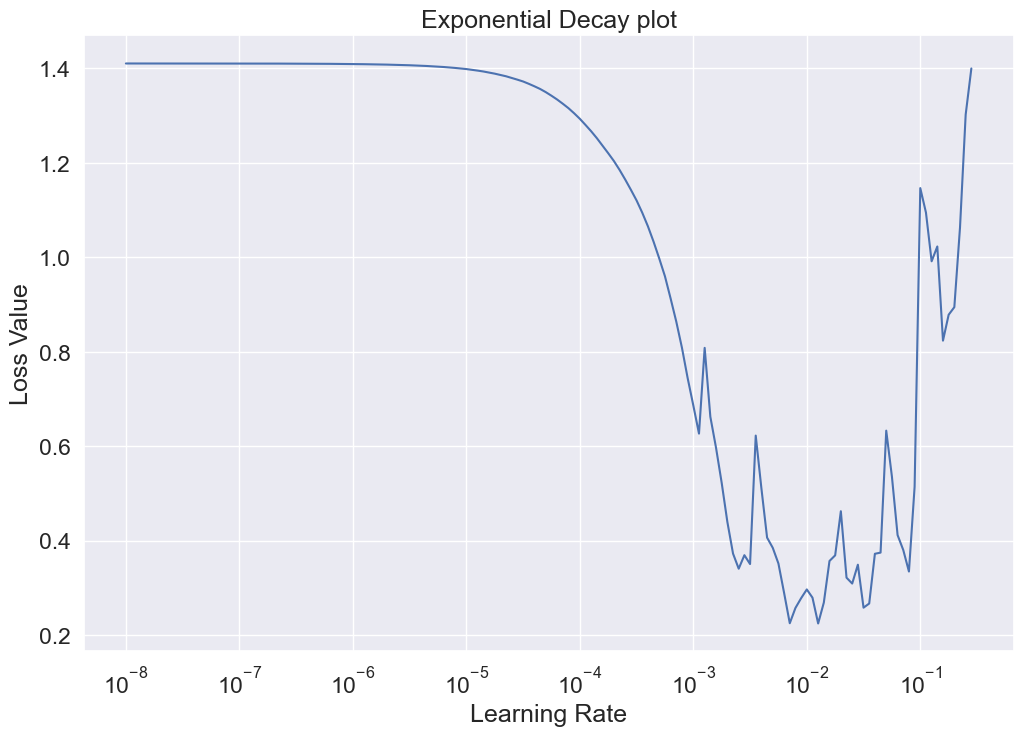

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax'),#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs= 150, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/150
9/9 [==============================] - 2s 66ms/step - loss: 1.1806 - accuracy: 0.3603 - val_loss: 1.0051 - val_accuracy: 0.6471
Epoch 2/150
9/9 [==============================] - 0s 24ms/step - loss: 0.9075 - accuracy: 0.5809 - val_loss: 1.0127 - val_accuracy: 0.5882
Epoch 3/150
9/9 [==============================] - 0s 11ms/step - loss: 0.7717 - accuracy: 0.6397 - val_loss: 0.8709 - val_accuracy: 0.7353
Epoch 4/150
9/9 [==============================] - 0s 11ms/step - loss: 0.6509 - accuracy: 0.7647 - val_loss: 0.7208 - val_accuracy: 0.7353
Epoch 5/150
9/9 [==============================] - 0s 11ms/step - loss: 0.5125 - accuracy: 0.8162 - val_loss: 0.7813 - val_accuracy: 0.6765
Epoch 6/150
9/9 [==============================] - 0s 11ms/step - loss: 0.3790 - accuracy: 0.8897 - val_loss: 0.6440 - val_accuracy: 0.7941
Epoch 7/150
9/9 [==============================] - 0s 11ms/step - loss: 0.3190 - accuracy: 0.8676 - val_loss: 0.7200 - val_accuracy: 0.7059
Epoch 8/150
9/9 [===

In [22]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 2.7910 - accuracy: 0.5581


[2.7910208702087402, 0.5581395626068115]

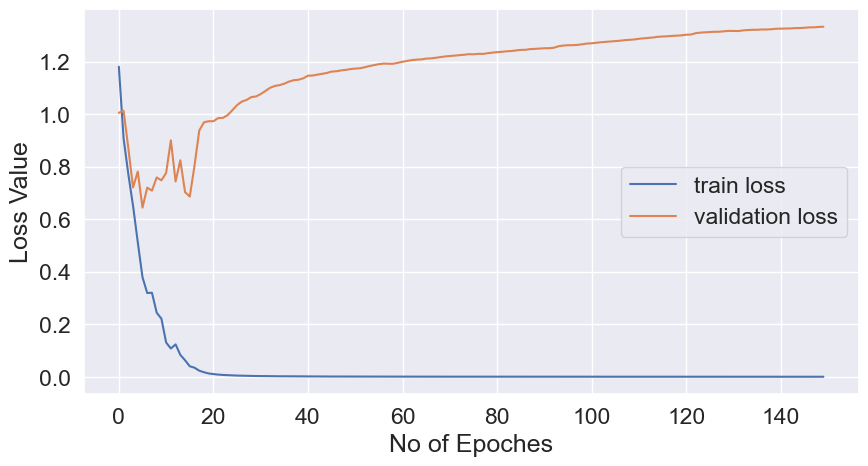

In [23]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

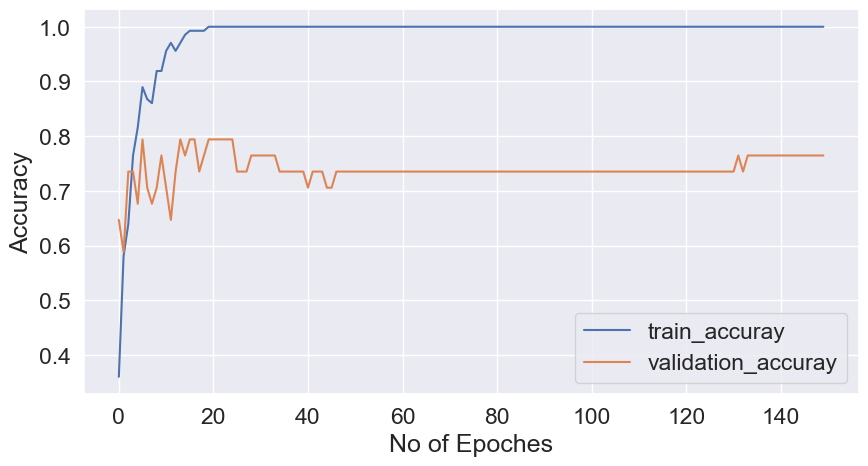

In [24]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'sit', 'stand','walk']
columns = ['Empty', 'sit', 'stand','walk']
df_cm = pd.DataFrame(confusion_matrix,columns,index) 

Text(0.5, 16.156249999999993, 'Predicted Activities')

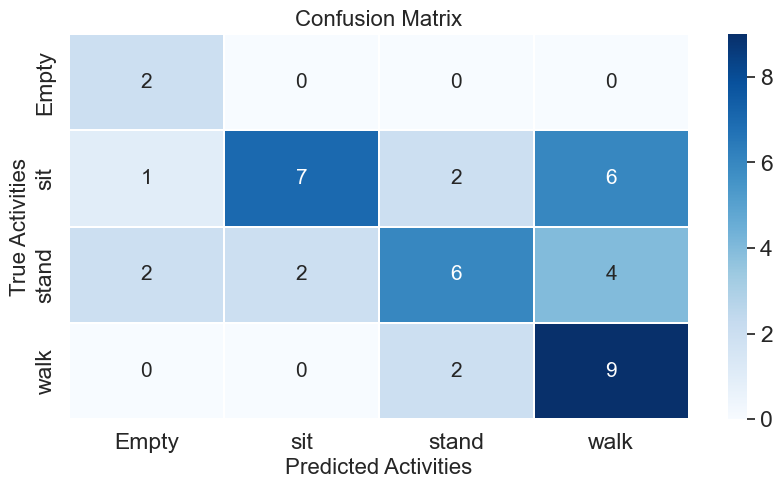

In [26]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [27]:
from sklearn.metrics import classification_report
target_names = ['Empty', 'sit', 'stand','walk']
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)) 

              precision    recall  f1-score   support

       Empty       0.40      1.00      0.57         2
         sit       0.78      0.44      0.56        16
       stand       0.60      0.43      0.50        14
        walk       0.47      0.82      0.60        11

    accuracy                           0.56        43
   macro avg       0.56      0.67      0.56        43
weighted avg       0.62      0.56      0.55        43



In [28]:
# save model
model.save('v2_model')

INFO:tensorflow:Assets written to: v2_model\assets


INFO:tensorflow:Assets written to: v2_model\assets


# Test with smaller batch size
Change: Reduce batch size from 16 to 4

In [29]:
activity_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = tf.keras.optimizers.Adam(learning_rate=1e-8)

activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model_history = activity_model.fit(X_train, y_train, epochs= 150, validation_split=0.2,  batch_size=4, callbacks = [lr_schedule])

Epoch 1/150
34/34 [==============================] - 2s 23ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4131 - val_accuracy: 0.0882 - lr: 1.0000e-08
Epoch 2/150
34/34 [==============================] - 0s 7ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4130 - val_accuracy: 0.0882 - lr: 1.1220e-08
Epoch 3/150
34/34 [==============================] - 0s 7ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4130 - val_accuracy: 0.0882 - lr: 1.2589e-08
Epoch 4/150
34/34 [==============================] - 0s 8ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4130 - val_accuracy: 0.0882 - lr: 1.4125e-08
Epoch 5/150
34/34 [==============================] - 0s 7ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4130 - val_accuracy: 0.0882 - lr: 1.5849e-08
Epoch 6/150
34/34 [==============================] - 0s 7ms/step - loss: 1.4460 - accuracy: 0.1324 - val_loss: 1.4130 - val_accuracy: 0.0882 - lr: 1.7783e-08
Epoch 7/150
34/34 [==============================] 

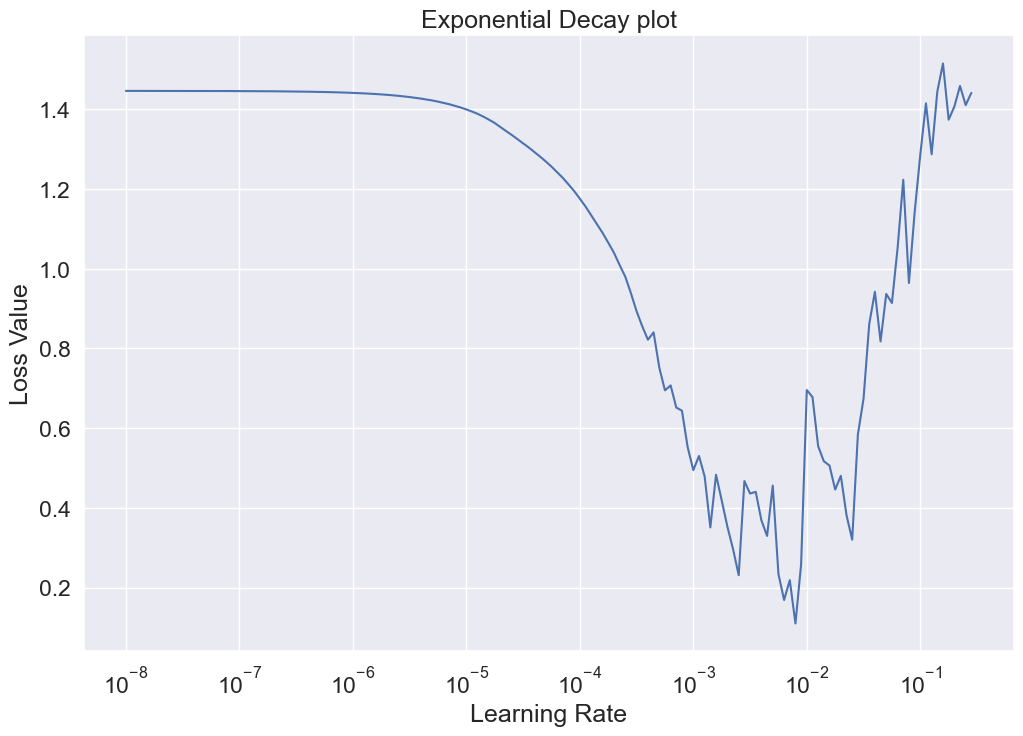

In [30]:
# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

In [31]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax'),#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs= 200, batch_size=4, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/200
 4/34 [==>...........................] - ETA: 0s - loss: 1.2422 - accuracy: 0.3750 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_train_batch_end` time: 0.0113s). Check your callbacks.


34/34 [==============================] - 2s 22ms/step - loss: 1.1993 - accuracy: 0.4118 - val_loss: 1.1484 - val_accuracy: 0.5294
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 1.0197 - accuracy: 0.5368 - val_loss: 0.9548 - val_accuracy: 0.4706
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.8442 - accuracy: 0.6397 - val_loss: 1.0336 - val_accuracy: 0.5588
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.7725 - accuracy: 0.6765 - val_loss: 0.9746 - val_accuracy: 0.5294
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.6645 - accuracy: 0.7059 - val_loss: 0.9298 - val_accuracy: 0.6176
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.5623 - accuracy: 0.7426 - val_loss: 0.8164 - val_accuracy: 0.6765
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 0.4917 - accuracy: 0.8382 - val_loss: 0.8877 - val_accuracy: 0.7059
Epoch 8/200
34/34 [=====

In [33]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 12ms/step - loss: 3.5671 - accuracy: 0.5349


[3.5670974254608154, 0.5348837375640869]

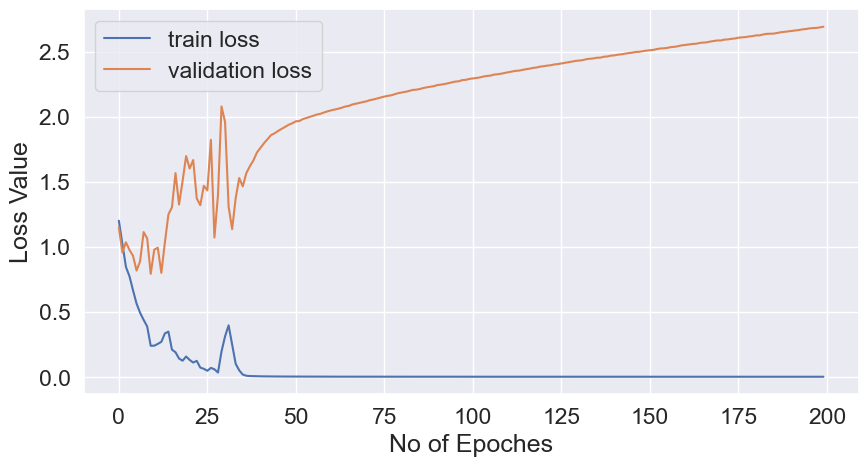

In [34]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

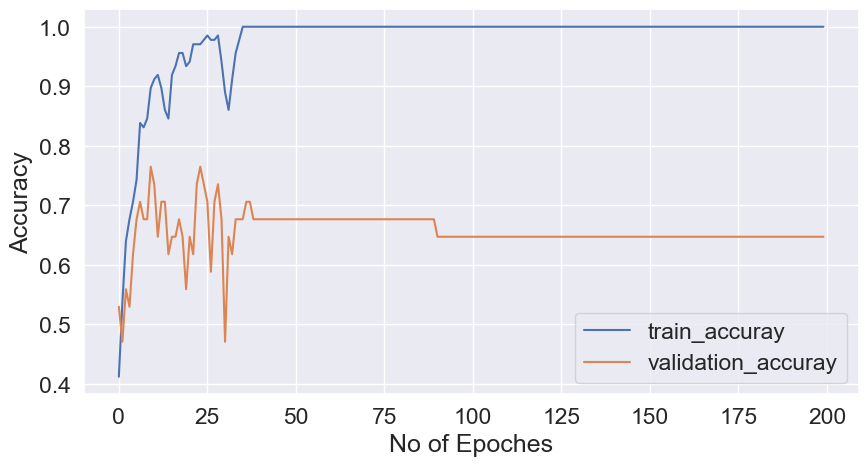

In [35]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'sit', 'stand','walk']
columns = ['Empty', 'sit', 'stand','walk']
df_cm = pd.DataFrame(confusion_matrix,columns,index) 

Text(0.5, 16.156249999999993, 'Predicted Activities')

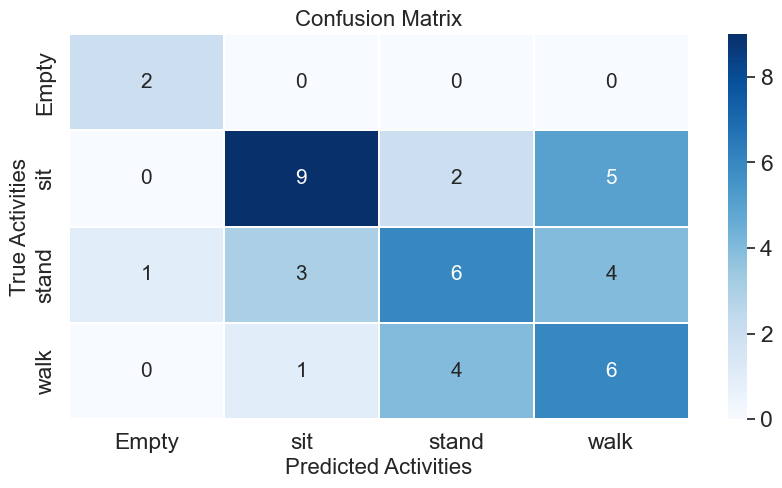

In [37]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [38]:
target_names = ['Empty', 'sit', 'stand','walk']
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)) 

              precision    recall  f1-score   support

       Empty       0.67      1.00      0.80         2
         sit       0.69      0.56      0.62        16
       stand       0.50      0.43      0.46        14
        walk       0.40      0.55      0.46        11

    accuracy                           0.53        43
   macro avg       0.56      0.63      0.59        43
weighted avg       0.55      0.53      0.54        43



In [39]:
# save model
model.save('v2.1_model')

INFO:tensorflow:Assets written to: v2.1_model\assets


INFO:tensorflow:Assets written to: v2.1_model\assets


Conclusion:
1. Changing batch size does not help
2. Learning rate of 1e-2 is the best (converges faster)
3. Amount of data is still too low to train a deep learning model. Hence, alternatives will be explored.